### Sensitivity to background subtraction miss of RRG and CNN estimators

In [ ]:
import math as ma
import numpy as np
import matplotlib.pyplot as plt

from os.path import expanduser

from wlenet import config
from wlenet.models.calibrate import step_bias_calib, step_bias_correct
from wlenet.models.utils import get_output_dim, load_model, load_spec, save_spec, print_spec
from wlenet.dataset.io import load_sim
from wlenet.dataset.sequences import CorrelatedNoiseSequence, generate_batches
from wlenet.dataset.normalization import norm_mean_std
from wlenet.reduction.stamps import half_light_radii

In [2]:
model_spec = load_spec('cnn_image_clash_uniform_mse')
test_sets = ['clash_003_test']
bg_miss_bins = np.array([0.03125, 0.0625, 0.125, 0.25])
num_batches = 2000
save_figures = True

In [3]:
model = load_model(model_spec, load_weights=True, show_summary=False)

In [4]:
noise_kernel_path = config['calibration_path'] + '/' +  model_spec['kwargs_dataset']['noise_kernel_name'] + '_noise_kernel.npy'
noise_kernel = np.load(expanduser(noise_kernel_path)) *  model_spec['kwargs_dataset']['noise_kernel_factor']
post_sim = model_spec['kwargs_dataset']['post_sim']
output_dim = get_output_dim(model)

In [5]:
from wlenet.reduction.stamps import half_light_radii, chi_shapes, rrg_shapes


def rrg_performance(x_seq_test, y_seq_test, max_radius=10, num_trials=60):
    
    psf_radius = (0.12 / 0.065) / 2.355    
    radii = half_light_radii(x_seq_test)
    y_rrg = rrg_shapes(x_seq_test, radii, psf_radius)
    inds = np.all(np.abs(y_rrg) < 1.0, axis=1)
    _, _, rmse = step_bias_calib(y_seq_test[inds, :], y_rrg[inds, :], verbose=False)

    return rmse

In [6]:
source_test = dict(zip(('x', 'y'), load_sim(test_sets, 'test', output_dim, post_sim=post_sim)))
seq_test = CorrelatedNoiseSequence(source_test, noise_kernel, norm_func=None)
x_seq_test, y_seq_test, inds_seq_test = generate_batches(seq_test, num_batches)

In [7]:
x_seq_radii = half_light_radii(x_seq_test).reshape(-1, 1, 1, 1)
x_seq_flux = np.sum(x_seq_test, axis=(1,2), keepdims=True)
x_seq_signal = x_seq_flux / (ma.pi * x_seq_radii**2)

In [8]:
test_rrg_rmse = np.zeros((len(bg_miss_bins), 2))

for i in range(len(bg_miss_bins)):

    bg_miss = (np.random.rand(len(x_seq_test), 1, 1, 1) - 0.5) * bg_miss_bins[i] * x_seq_signal
    test_rrg_rmse[i, :] = rrg_performance(x_seq_test + bg_miss, y_seq_test)    

    print(source_test['x'].shape[0])
    print(test_rrg_rmse[i, :])

308000
[0.2678359  0.26797454]
308000
[0.28244337 0.28423512]
308000
[0.30575234 0.30819911]
308000
[0.34282295 0.34885557]


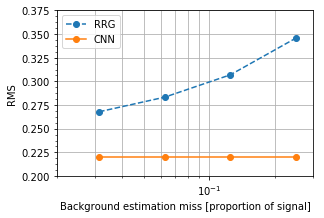

In [9]:
plt.rcParams['figure.figsize'] = (4.75,3.15)
fig, ax1 = plt.subplots()
cnn_rmse = [0.220047905] * len(bg_miss_bins)

ax1.set_xlabel('Background estimation miss [proportion of signal]')
ax1.set_ylabel('RMS')
ax1.semilogx(bg_miss_bins, np.mean(test_rrg_rmse, 1), 'o--', label='RRG')
ax1.semilogx(bg_miss_bins, cnn_rmse, 'o-', label='CNN')

plt.ylim([0.20, 0.375])
plt.xlim([0.02, 0.3])
plt.grid('on', which='major', axis='both')
plt.grid('on', which='minor', axis='x')
ax1.minorticks_on()
ax1.legend(loc='upper left')
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/performance/sensitivity_to_bgsub.pdf')
    plt.savefig(fig_path)

Reduced shear RMSE of the CNN estimator and RRG estimator for galaxies simulated to match the CLASH magnitude-radius distribution for varying background subtraction estimation miss.